In [1]:
import os
import random
import shutil
from multiprocessing.dummy import Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import joblib
from skimage.morphology import binary_opening, disk, label
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from  torchvision.transforms import *
import torchvision.transforms as transforms
from fastai.vision.all import *

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<h1  style="padding:20px;color:white;margin:0;font-size:200%;text-align:left;display:fill;border-radius:15px;background-color:	#1E90FF;overflow:hidden"><center> Airbus Ship Detection Challenge </center></h1>
    
<img src = "https://www.mdpi.com/sensors/sensors-22-02713/article_deploy/html/images/sensors-22-02713-g006.png" >

> ## [**1. Load Data**](#title-one)
 >## [**2. Model Unet**](#title-two)
 >## [**3. Submission**](#title-three)

<a id='title-one'></a>
<div class="list-group" id="list-tab" role="tablist">
<h1  style="padding:20px;color:white;margin:0;font-size:200%;text-align:left;display:fill;border-radius:15px;background-color:	#1E90FF;overflow:hidden"> Load Data</h1>


In [2]:
def decode_mask(mask, shape=(768, 768)):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] +1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle_decode(mask_rle, shape=(768, 768)):
    if not isinstance(mask_rle, str):
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    im = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        im[lo:hi] = 1
    return im.reshape(shape).T

In [3]:
class param:
    img_size = (768, 768)
    bs = 8
    num_workers = 4
    lr = 0.001
    epochs = 100
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 70

In [4]:
PATH = './'
TRAIN = 'train_v2/'
TEST = 'test_v2/'
SEGMENTATION = 'train_ship_segmentations_v2.csv'
DETECTION_TEST_PRED = 'ship_detection.csv'
train_dpath = 'train_v2/'
anno_path = 'train_ship_segmentation_v2.csv'
excluded_filenames = ['6384c3e78.jpg', ]
original_img_size = (768, 768)

In [5]:
annos = pd.read_csv('train_ship_segmentations_v2.csv')

In [6]:
annos['EncodedPixels_flag'] = annos['EncodedPixels'].map(lambda x: 1 if isinstance(x,str) else 0)

In [7]:
imgs = annos.groupby('ImageId').agg({'EncodedPixels_flag':'sum'}).reset_index().rename(columns={'EncodedPixels_flag':'ships'})

In [8]:
imgs_w_ships = imgs[imgs['ships'] > 0]
imgs_wo_ships = imgs[imgs['ships'] == 0].sample(20_000,random_state=69278)

selected_imgs = pd.concat([imgs_w_ships,imgs_wo_ships])
selected_imgs['has_ships'] = selected_imgs['ships'] >0

In [9]:
train_imgs, val_imgs = train_test_split(selected_imgs,test_size=0.01,stratify=selected_imgs['has_ships'],random_state=123) 

In [10]:
train_imgs, val_imgs = train_test_split(selected_imgs,test_size=0.15,stratify=selected_imgs['has_ships'],random_state=123) 
train_fnames = train_imgs['ImageId'].values
val_fnames = val_imgs['ImageId'].values
test_fnames = pd.read_csv('sample_submission_v2.csv')['ImageId'].values
#p ,train_fnames =  train_test_split(train_fnames,test_size=0.1,random_state=123)
#p_1,val_fnames =  train_test_split(val_fnames,test_size=0.1,random_state=123)
print(f"""Train = {len(train_fnames)} val  = {len(val_fnames)} """)

Train = 53172 val  = 9384 


In [11]:
train_imgs.groupby('has_ships').count()

,ImageId,ships
has_ships,,
False,17000,17000
True,36172,36172


In [12]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_dpath,
                 img_fnames,
                 img_transform,
                 mask_encodings=None,
                 mask_size=None,
                 mask_transform=None):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath)
        if self.img_transform is not None:
            random.seed(seed)
            img = self.img_transform(img)

        if self.mask_encodings is None:
            img =  self.img_transform(Image.open(fpath))
            return img, 0,self.img_fnames[i]

        if self.mask_size is None or self.mask_transform is None:
            raise ValueError('If mask_dpath is not None, mask_size and mask_transform must not be None.')

        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if self.mask_encodings[fname][0] == self.mask_encodings[fname][0]: # NaN doesn't equal to itself
            for encoding in self.mask_encodings[fname]:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(mask)

        random.seed(seed)
        mask = self.mask_transform(mask)
        img = self.img_transform(Image.open(fpath))
        return  img, torch.from_numpy(np.array(mask, dtype=np.int64)),self.img_fnames[i]

    def __len__(self):
        return len(self.img_fnames)

In [13]:
def get_mask_encodings(annos,fnames):
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()

In [14]:
train_tfms = transforms.Compose([
                                 ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),transforms.Resize(param.img_size),transforms.ToTensor()])
val_tfms = transforms.Compose([
                               ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),transforms.Resize(param.img_size),transforms.ToTensor()])
test_tfms =transforms.Compose([
                               ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),transforms.ToTensor()])
mask_tfms = transforms.Compose([transforms.Resize(param.img_size)])

In [15]:
train_ds = ImgDataset(train_dpath, train_fnames, train_tfms, get_mask_encodings(annos, train_fnames), original_img_size, mask_tfms)
val_ds = ImgDataset(train_dpath, val_fnames, val_tfms, get_mask_encodings(annos, val_fnames), original_img_size, mask_tfms)
test_ds = ImgDataset(TEST, test_fnames, val_tfms, None, original_img_size, None)

In [16]:
train_dl = DataLoader(train_ds,
                      batch_size=param.bs,num_workers=2,
                      shuffle=True)
val_dl = DataLoader(val_ds,
                    batch_size=param.bs,num_workers=2,
                    shuffle=False)
test_dl = DataLoader(test_ds,
                    batch_size=5,num_workers=2,
                    shuffle=False)

<a id='title-two'></a>
<div class="list-group" id="list-tab" role="tablist">
<h1  style="padding:20px;color:white;margin:0;font-size:200%;text-align:left;display:fill;border-radius:15px;background-color:	#1E90FF;overflow:hidden">Model</h1>

In [19]:
class UnetBlock(nn.Module):
    
    def __init__(self,up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class SaveFeatures():
    
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
        
class Unet(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
 
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        print(1)
        for sf in self.sfs: sf.remove()
    

In [20]:
arch = resnet34
cut = model_meta[arch]['cut']

In [21]:
model_meta[arch]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [30]:
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

def load_pretrained(model): #load a model pretrained on ship/no-ship classification
    
    weights = torch.load('resnet34_clas', map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)
            
    return model

In [31]:
rn = load_pretrained(get_base())

In [32]:
X = train_ds[0][0].reshape(1,3,768,768)
X.shape

torch.Size([1, 3, 768, 768])

In [33]:
torch.cuda.empty_cache()

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [35]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [36]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [37]:
model = Unet(rn)

In [ ]:
params_to_update = []
params_to_update_2 = []
for name, param in model.named_parameters():
    if  'rn.' not in name:
        params_to_update.append(param)
        print("\t",name)
    else:
        params_to_update_2.append(param)
        print("\t",name)
        
optim = torch.optim.Adam([ {'params': params_to_update, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr':1e-6}],weight_decay=1e-7)

In [ ]:
torch.cuda.empty_cache()
from tqdm.auto import tqdm
dev = 'cuda'
model = model.to(dev)
loss = MixedLoss(10.0, 2.0)

for epoch in tqdm(range(20)):
    for i,(X,y,_) in enumerate(train_dl):
        optim.zero_grad()
        X ,y = X.to(dev),y.to(dev)
        pred = model(X)
        l = loss(pred,y)
        l.backward()
        optim.step()
        if i %100 == 0:
            print(l.item())

In [69]:
def results(x,yp,yt):
    columns = 3
    rows = min(x.shape[0],8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        fig.add_subplot(rows, columns, 3*i+1)
        plt.axis('off')
        plt.imshow(x[i].permute(1, 2, 0))
        fig.add_subplot(rows, columns, 3*i+2)
        plt.axis('off')
        plt.imshow(yp[i])
        fig.add_subplot(rows, columns, 3*i+3)
        plt.axis('off')
        plt.imshow(yt[i])
    plt.show()

In [70]:
torch.cuda.empty_cache()
model.eval()

for X,y,_ in val_dl:
    X ,y = X.to(dev),y.to(dev)
    
    pred  = model(X)
    break

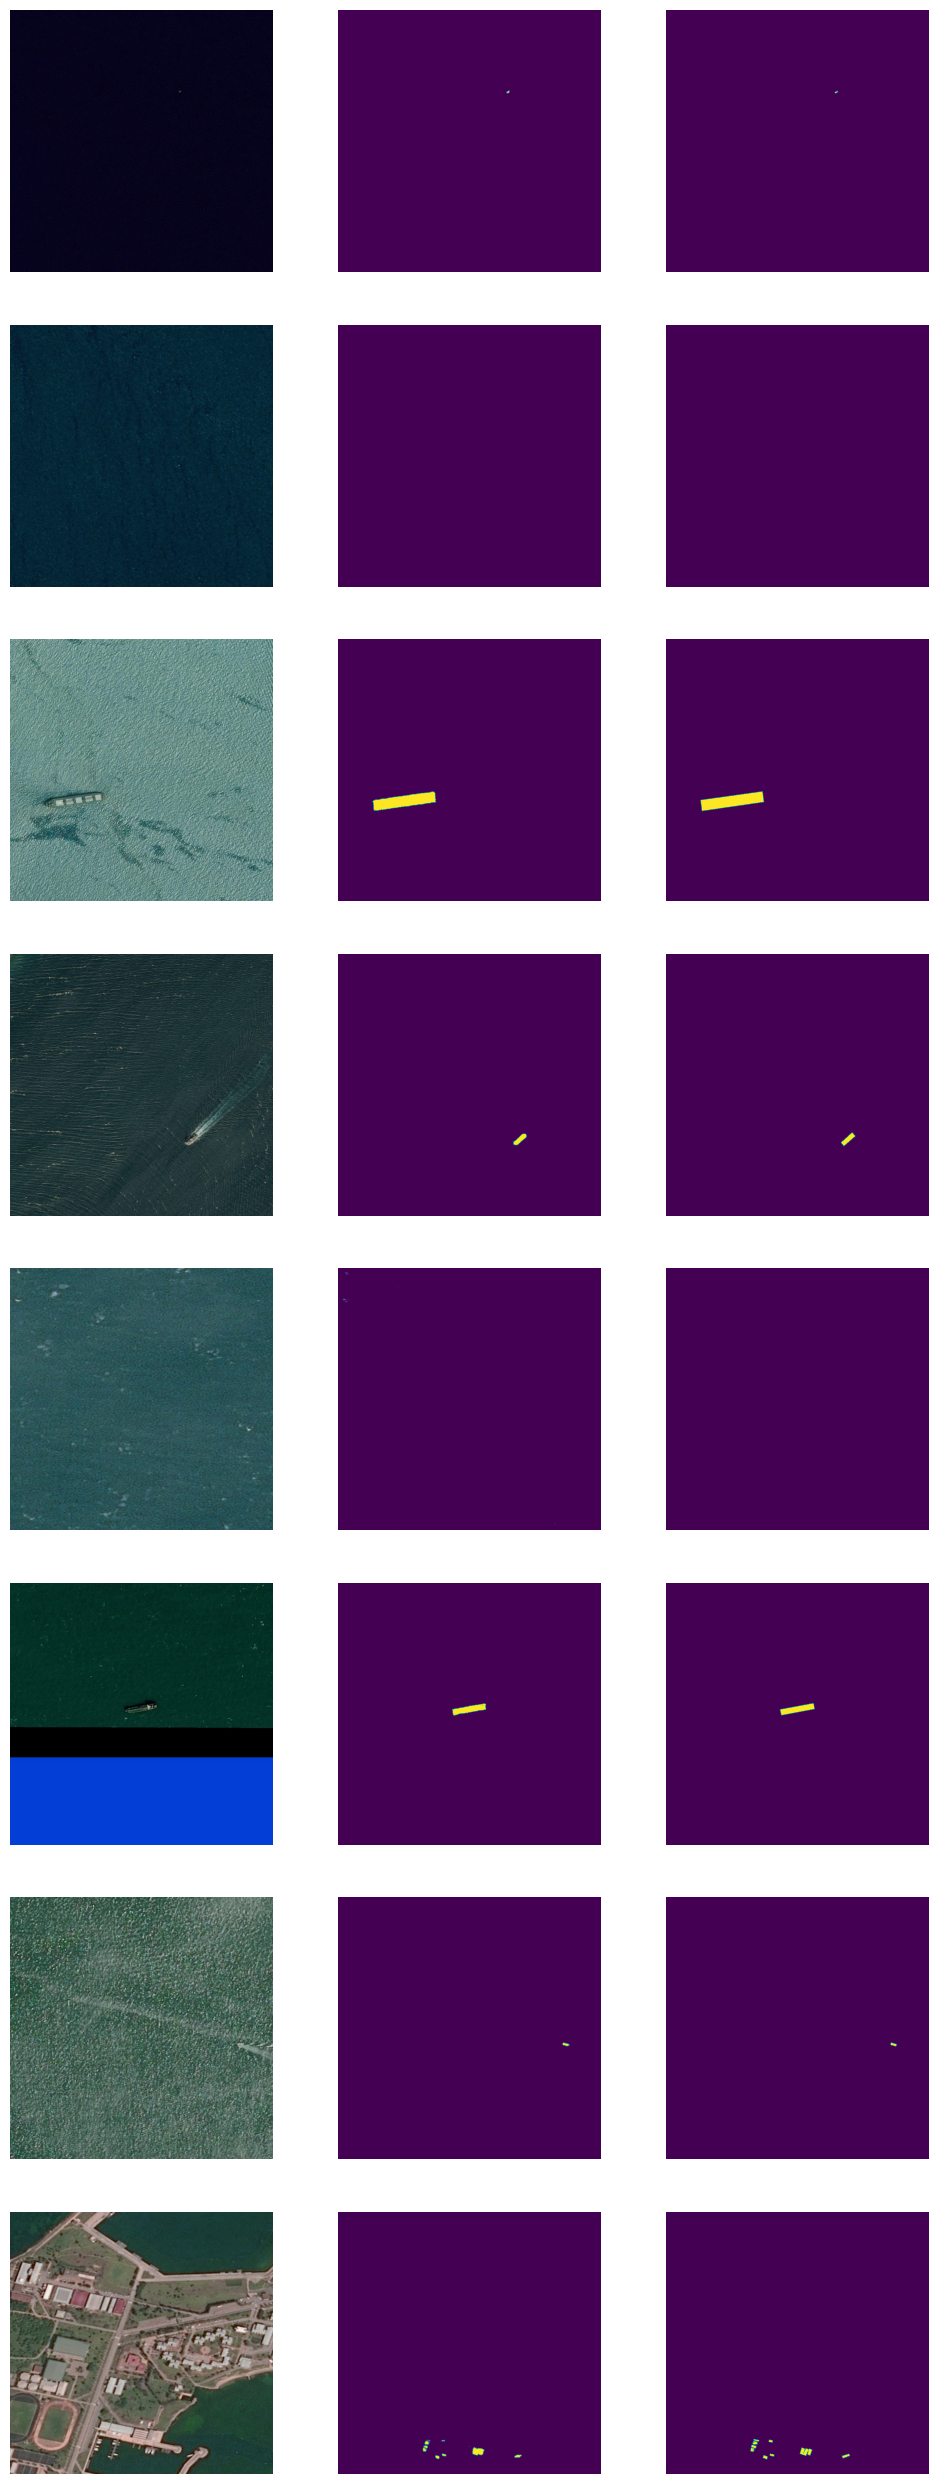

In [71]:
num_item = 0
results(X.to('cpu'),torch.sigmoid(pred.detach().cpu()),y.to('cpu'))

In [61]:
torch.save(model.state_dict(),'unet_final')

<a id='title-three'></a>
<div class="list-group" id="list-tab" role="tablist">
<h1  style="padding:20px;color:white;margin:0;font-size:200%;text-align:left;display:fill;border-radius:15px;background-color:	#1E90FF;overflow:hidden"> Submission</h1>

In [24]:
model2 = Unet(rn)

In [25]:
model2.load_state_dict(torch.load('unet_final'))

<All keys matched successfully>

In [72]:
torch.cuda.empty_cache()
dev = 'cuda'
model = model.to(dev)
final = pd.DataFrame()
for i, (X, _,name) in enumerate(test_dl):
    tmp = pd.DataFrame()
    X = X.to('cuda')
    output = model(X)
    a = torch.sigmoid(output)
    code = [decode_mask(torch.where(x>0.6,torch.tensor(1),torch.tensor(0)).to('cpu').int()) for x in a]
    tmp['ImageId'] = name
    tmp['EncodedPixels'] = code
    final = pd.concat([final,tmp],ignore_index=True)

In [73]:
final.to_csv('final.csv',index=False)

In [79]:
df1 = pd.read_csv('prob.csv')

In [80]:
img = df1[df1['ship']<0.5]['ImageId'].tolist()

In [84]:
df = pd.read_csv('final.csv')

In [82]:
df.loc[df['ImageId'].isin(img),'EncodedPixels'] = np.nan

In [85]:
df.to_csv('sub.csv',index=False)